# Lecture 5: Fixed-Income Securities II — Duration, Convexity, Credit Risk, and Securitization

## MIT 15.401 — Finance Theory I (Prof. Andrew Lo)

---

**Video:** [MIT OCW — Part III & IV of Fixed-Income Securities](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/fixed-income-securities/)

**Readings:** Brealey, Myers, and Allen — Chapters 23–25; Sundaresan, *Fixed Income Markets and Their Derivatives*

---

This notebook completes the **Fixed-Income Securities** block (Sessions 4–7 in Lo's numbering). We move from bond pricing to **risk measurement**, asking: once you own a bond, how sensitive is your position to changes in interest rates? The answers — **duration** and **convexity** — are the foundational tools of fixed-income risk management.

We then shift from riskless government debt to **corporate bonds**, where **default risk** introduces an entirely new dimension. The session culminates with Lo's remarkable real-time case study of the **sub-prime crisis and securitization**, taught as Lehman Brothers was collapsing. His simple two-bond CDO example demonstrates how correlation assumptions can destroy the supposed safety of senior tranches — the mechanism at the heart of the 2008 financial crisis.

## Table of Contents

1. [Macaulay Duration](#1-duration)
2. [Modified Duration and Dollar Duration](#2-modified-duration)
3. [Convexity](#3-convexity)
4. [Duration-Convexity Approximation](#4-approx)
5. [Immunization and Hedging](#5-immunization)
6. [Corporate Bonds and Default Risk](#6-credit-risk)
7. [Securitization and the Sub-Prime Crisis](#7-securitization)
8. [Exercises](#8-exercises)

In [3]:
# ============================================================
# Setup
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import brentq
from IPython.display import display, Markdown

plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'lines.linewidth': 2,
})

# Bond toolkit from Session 4
def bond_price_from_ytm(face, coupon_rate, maturity, ytm, freq=1):
    C = face * coupon_rate / freq
    n = maturity * freq
    y = ytm / freq
    price = sum(C / (1 + y)**t for t in range(1, n + 1))
    price += face / (1 + y)**n
    return price

def compute_ytm(price, face, coupon_rate, maturity, freq=1):
    def f(y):
        return bond_price_from_ytm(face, coupon_rate, maturity, y, freq) - price
    return brentq(f, -0.05, 2.0)

print("Libraries and bond toolkit loaded.")

Libraries and bond toolkit loaded.


---

<a id='1-duration'></a>
## 1. Macaulay Duration

### Motivation

We showed in Session 4 that bond prices move inversely with yields. But *how much* does a bond's price change for a given yield movement? This is the central question of **interest rate risk management**.

Frederick Macaulay (1938) proposed an elegant answer: **duration** — a single number that captures a bond's price sensitivity to yield changes.

### Definition

**Macaulay duration** $D$ is the **weighted average time to receipt of cash flows**, where the weights are the present values of each cash flow as a fraction of the bond price:

$$\boxed{D = \sum_{k=1}^{T} k \cdot \omega_k}$$

where

$$\omega_k = \frac{PV(CF_k)}{P} = \frac{CF_k / (1+y)^k}{P}, \qquad \sum_{k=1}^{T} \omega_k = 1$$

Duration is measured in **years** (or half-years for semi-annual bonds). It tells you the bond's "effective maturity" — the average time you wait to receive your money, weighted by economic importance.

### Key Properties of Macaulay Duration

1. **Zero-coupon bond:** $D = T$ (all weight on the single payment at maturity)
2. **Coupon bond:** $D < T$ (coupons pull the weighted average inward)
3. **Duration decreases with coupon rate** (more early cash flows)
4. **Duration decreases with YTM** (higher discounting reduces weight of distant flows)
5. **Duration usually increases with maturity** (for bonds at or above par, always; for deep discount bonds, can decrease — rare in practice)
6. **Perpetuity:** $D = (1+y)/y$

In [5]:
# ============================================================
# Macaulay Duration Calculation
# ============================================================

def macaulay_duration(face, coupon_rate, maturity, ytm, freq=1):
    """Compute Macaulay duration.
    
    For semi-annual bonds (freq=2), returns duration in YEARS
    (i.e., divides by freq at the end).
    """
    C = face * coupon_rate / freq
    n = maturity * freq
    y = ytm / freq
    
    price = bond_price_from_ytm(face, coupon_rate, maturity, ytm, freq)
    
    weighted_sum = 0
    for k in range(1, n + 1):
        cf = C if k < n else C + face
        pv_cf = cf / (1 + y)**k
        weighted_sum += k * pv_cf
    
    return weighted_sum / (price * freq)  # Convert to annual


# Lo's example from slide 37: 4-year T-note, 7% coupon, 6% yield, semi-annual
face = 100
coupon_rate = 0.07
maturity = 4
ytm = 0.06
freq = 2

C = face * coupon_rate / freq  # 3.5 semi-annual coupon
n = maturity * freq             # 8 periods
y = ytm / freq                  # 3% per period

price = bond_price_from_ytm(face, coupon_rate, maturity, ytm, freq)
D = macaulay_duration(face, coupon_rate, maturity, ytm, freq)

print("=" * 75)
print("MACAULAY DURATION — Lo's T-Note Example")
print(f"4-Year T-Note, {coupon_rate:.0%} coupon (semi-annual), YTM = {ytm:.0%}")
print("=" * 75)
print(f"{'Period k':>10s} {'CF':>8s} {'PV(CF)':>12s} {'Weight ωk':>12s} {'k × ωk':>12s}")
print("-" * 55)

total_w = 0
total_kw = 0
for k in range(1, n + 1):
    cf = C if k < n else C + face
    pv_cf = cf / (1 + y)**k
    w = pv_cf / price
    kw = k * w
    total_w += w
    total_kw += kw
    print(f"{k:>10d} {cf:>8.2f} {pv_cf:>12.4f} {w:>12.6f} {kw:>12.6f}")

print("-" * 55)
print(f"{'SUM':>10s} {'':>8s} {price:>12.4f} {total_w:>12.6f} {total_kw:>12.6f}")
print(f"\nMacaulay Duration (half-year units): D = {total_kw:.2f} half-years")
print(f"Macaulay Duration (annual):          D = {total_kw / freq:.2f} years")
print(f"Bond Price: ${price:.2f} (per $100 face)")

MACAULAY DURATION — Lo's T-Note Example
4-Year T-Note, 7% coupon (semi-annual), YTM = 6%
  Period k       CF       PV(CF)    Weight ωk       k × ωk
-------------------------------------------------------
         1     3.50       3.3981     0.032828     0.032828
         2     3.50       3.2991     0.031872     0.063744
         3     3.50       3.2030     0.030944     0.092832
         4     3.50       3.1097     0.030043     0.120170
         5     3.50       3.0191     0.029168     0.145838
         6     3.50       2.9312     0.028318     0.169908
         7     3.50       2.8458     0.027493     0.192453
         8   103.50      81.7039     0.789334     6.314673
-------------------------------------------------------
       SUM              103.5098     1.000000     7.132447

Macaulay Duration (half-year units): D = 7.13 half-years
Macaulay Duration (annual):          D = 3.57 years
Bond Price: $103.51 (per $100 face)


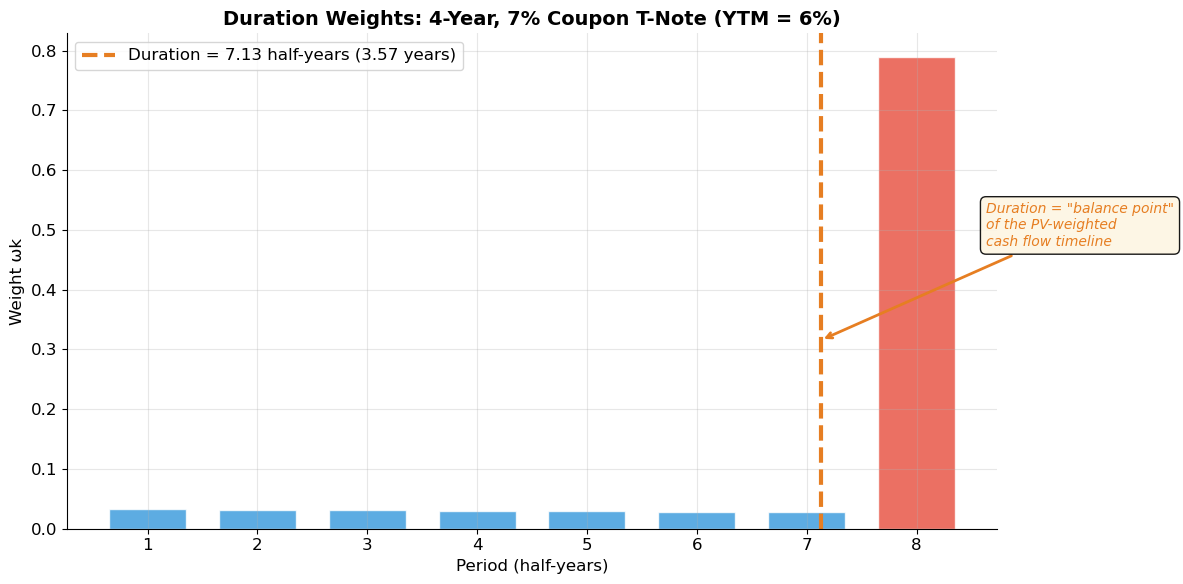

The last bar (period 8) is much larger because it includes the principal repayment.
Weight on final period: 78.9% of total PV


In [6]:
# ============================================================
# Duration Weights — Visualization
# ============================================================
weights = []
periods = list(range(1, n + 1))
for k in periods:
    cf = C if k < n else C + face
    pv_cf = cf / (1 + y)**k
    weights.append(pv_cf / price)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#3498db'] * (n - 1) + ['#e74c3c']
ax.bar(periods, weights, color=colors, alpha=0.8, edgecolor='white', width=0.7)

# Duration line
D_halfyears = sum(k * w for k, w in zip(periods, weights))
ax.axvline(x=D_halfyears, color='#e67e22', linewidth=3, linestyle='--',
           label=f'Duration = {D_halfyears:.2f} half-years ({D_halfyears/2:.2f} years)')

# Fulcrum analogy
ax.annotate('Duration = "balance point"\nof the PV-weighted\ncash flow timeline',
            xy=(D_halfyears, max(weights) * 0.4),
            xytext=(D_halfyears + 1.5, max(weights) * 0.6),
            fontsize=10, color='#e67e22', style='italic',
            arrowprops=dict(arrowstyle='->', color='#e67e22', lw=2),
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#fdf6e3', alpha=0.9))

ax.set_xlabel('Period (half-years)', fontsize=12)
ax.set_ylabel('Weight ωk', fontsize=12)
ax.set_title(f'Duration Weights: 4-Year, {coupon_rate:.0%} Coupon T-Note (YTM = {ytm:.0%})',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.set_xticks(periods)

plt.tight_layout()
plt.show()

print("The last bar (period 8) is much larger because it includes the principal repayment.")
print(f"Weight on final period: {weights[-1]:.1%} of total PV")

---

<a id='2-modified-duration'></a>
## 2. Modified Duration and Dollar Duration

### From Duration to Price Sensitivity

The mathematical connection between Macaulay duration and price sensitivity comes from calculus. Taking the derivative of the bond price with respect to yield:

$$\frac{1}{P} \frac{\partial P}{\partial y} = -\frac{D}{1 + y/q}$$

where $q$ is the compounding frequency per year.

### Modified Duration

**Modified duration** $D^*$ adjusts Macaulay duration for the compounding frequency:

$$\boxed{D^* = \frac{D}{1 + y/q}}$$

Modified duration gives us the **percentage price change** for a small yield change:

$$\frac{\Delta P}{P} \approx -D^* \times \Delta y$$

### Dollar Duration

Sometimes we want the **dollar** (not percentage) price change:

$$\boxed{\Delta P \approx -D^* \times P \times \Delta y}$$

The quantity $D^* \times P$ is called the **dollar duration** or **DV01** (dollar value of one basis point, when $\Delta y = 0.0001$).

In [8]:
# ============================================================
# Modified Duration and Price Sensitivity
# ============================================================

def modified_duration(face, coupon_rate, maturity, ytm, freq=1):
    D = macaulay_duration(face, coupon_rate, maturity, ytm, freq)
    return D / (1 + ytm / freq)

def dollar_duration(face, coupon_rate, maturity, ytm, freq=1):
    price = bond_price_from_ytm(face, coupon_rate, maturity, ytm, freq)
    Dmod = modified_duration(face, coupon_rate, maturity, ytm, freq)
    return Dmod * price

# Lo's example continued
D_mac = macaulay_duration(100, 0.07, 4, 0.06, 2)
D_mod = modified_duration(100, 0.07, 4, 0.06, 2)
price_base = bond_price_from_ytm(100, 0.07, 4, 0.06, 2)
DD = dollar_duration(100, 0.07, 4, 0.06, 2)
DV01 = DD * 0.0001

print("=" * 60)
print("MODIFIED DURATION — Lo's T-Note Example")
print("=" * 60)
print(f"Macaulay Duration:  D  = {D_mac:.4f} years")
print(f"Modified Duration:  D* = D/(1+y/2) = {D_mac:.4f}/{1+0.03:.2f} = {D_mod:.4f}")
print(f"Bond Price:         P  = ${price_base:.4f}")
print(f"Dollar Duration:    D* × P = {D_mod:.4f} × {price_base:.4f} = {DD:.4f}")
print(f"DV01 (per $100):    {DV01:.4f}")

# Price change prediction
dy = 0.001  # 10 basis points
predicted_change = -D_mod * dy * 100  # in percentage
actual_new_price = bond_price_from_ytm(100, 0.07, 4, 0.06 + dy, 2)
actual_change = (actual_new_price - price_base) / price_base * 100

print(f"\nIf yield rises by {dy*10000:.0f} bps ({dy:.2%}):")
print(f"  Duration approximation: ΔP/P ≈ -{D_mod:.4f} × {dy} = {predicted_change:+.4f}%")
print(f"  Actual price change:    ΔP/P = {actual_change:+.4f}%")
print(f"  Approximation error:    {abs(predicted_change - actual_change):.4f} percentage points")

# Larger move
dy2 = 0.02  # 200 bps
pred2 = -D_mod * dy2 * 100
actual2 = (bond_price_from_ytm(100, 0.07, 4, 0.06 + dy2, 2) - price_base) / price_base * 100
print(f"\nIf yield rises by {dy2*10000:.0f} bps ({dy2:.1%}):")
print(f"  Duration approximation: ΔP/P ≈ {pred2:+.4f}%")
print(f"  Actual price change:    ΔP/P = {actual2:+.4f}%")
print(f"  Approximation error:    {abs(pred2 - actual2):.4f} pp  ← error grows for large moves!")

MODIFIED DURATION — Lo's T-Note Example
Macaulay Duration:  D  = 3.5662 years
Modified Duration:  D* = D/(1+y/2) = 3.5662/1.03 = 3.4624
Bond Price:         P  = $103.5098
Dollar Duration:    D* × P = 3.4624 × 103.5098 = 358.3876
DV01 (per $100):    0.0358

If yield rises by 10 bps (0.10%):
  Duration approximation: ΔP/P ≈ -3.4624 × 0.001 = -0.3462%
  Actual price change:    ΔP/P = -0.3455%
  Approximation error:    0.0007 percentage points

If yield rises by 200 bps (2.0%):
  Duration approximation: ΔP/P ≈ -6.9247%
  Actual price change:    ΔP/P = -6.6431%
  Approximation error:    0.2816 pp  ← error grows for large moves!


In [9]:
# ============================================================
# Duration Across Bond Types — Comparative Analysis
# ============================================================
print("=" * 75)
print("DURATION COMPARISON ACROSS BOND TYPES")
print("=" * 75)
print(f"{'Bond':>30s} {'Price':>8s} {'Mac D':>8s} {'Mod D':>8s} {'DV01':>8s}")
print("-" * 75)

bonds = [
    ('Zero-coupon, 5yr',        1000, 0.00, 5,  0.05, 1),
    ('Zero-coupon, 10yr',       1000, 0.00, 10, 0.05, 1),
    ('Zero-coupon, 30yr',       1000, 0.00, 30, 0.05, 1),
    ('3% coupon, 10yr',         1000, 0.03, 10, 0.05, 1),
    ('5% coupon, 10yr (par)',   1000, 0.05, 10, 0.05, 1),
    ('8% coupon, 10yr',         1000, 0.08, 10, 0.05, 1),
    ('5% coupon, 2yr',          1000, 0.05, 2,  0.05, 1),
    ('5% coupon, 30yr',         1000, 0.05, 30, 0.05, 1),
    ('7% semi-annual, 4yr',     100,  0.07, 4,  0.06, 2),
]

results = []
for name, F, c, T, y, freq in bonds:
    P = bond_price_from_ytm(F, c, T, y, freq)
    Dm = macaulay_duration(F, c, T, y, freq)
    Dmod = modified_duration(F, c, T, y, freq)
    dv01 = Dmod * P * 0.0001
    results.append((name, P, Dm, Dmod, dv01, T))
    # Normalize price to per-100
    P_100 = P / F * 100 if F != 100 else P
    dv01_100 = dv01 / F * 100 if F != 100 else dv01
    print(f"{name:>30s} {P_100:>8.2f} {Dm:>8.2f} {Dmod:>8.2f} {dv01_100:>8.4f}")

print("\nKey patterns:")
print("• Zero-coupon: D = T always (no coupons to pull weighted average inward)")
print("• Higher coupon → lower duration (more early cash flows)")
print("• Longer maturity → higher duration (usually)")
print("• Higher yield → lower duration (distant cash flows discounted more heavily)")

DURATION COMPARISON ACROSS BOND TYPES
                          Bond    Price    Mac D    Mod D     DV01
---------------------------------------------------------------------------
              Zero-coupon, 5yr    78.35     5.00     4.76   0.0373
             Zero-coupon, 10yr    61.39    10.00     9.52   0.0585
             Zero-coupon, 30yr    23.14    30.00    28.57   0.0661
               3% coupon, 10yr    84.56     8.66     8.25   0.0697
         5% coupon, 10yr (par)   100.00     8.11     7.72   0.0772
               8% coupon, 10yr   123.17     7.54     7.18   0.0885
                5% coupon, 2yr   100.00     1.95     1.86   0.0186
               5% coupon, 30yr   100.00    16.14    15.37   0.1537
           7% semi-annual, 4yr   103.51     3.57     3.46   0.0358

Key patterns:
• Zero-coupon: D = T always (no coupons to pull weighted average inward)
• Higher coupon → lower duration (more early cash flows)
• Longer maturity → higher duration (usually)
• Higher yield → lower du

---

<a id='3-convexity'></a>
## 3. Convexity

### Why Duration Isn't Enough

Duration gives us a **linear approximation** to the price-yield relationship. But we know from Session 4 that this relationship is **curved** (convex). For large yield changes, the linear approximation becomes inaccurate.

### Definition

**Convexity** $V$ measures the curvature — it is the **second derivative** of the price with respect to yield, normalized by price:

$$\boxed{V = \frac{1}{P} \frac{\partial^2 P}{\partial y^2} = \frac{1}{(1+y/q)^2} \sum_{k=1}^{T} \frac{k(k+1) \cdot CF_k}{q^2 \cdot P \cdot (1 + y/q)^k}}$$

### Key Properties

1. **Convexity is always positive** for standard bonds (no embedded options)
2. **Higher convexity is desirable**: for the same duration, a more convex bond gains more when yields fall and loses less when yields rise — a "free lunch" in interest rate risk
3. **Longer maturity → higher convexity**
4. **Lower coupon → higher convexity** (same pattern as duration)

In [11]:
# ============================================================
# Convexity Calculation
# ============================================================

def bond_convexity(face, coupon_rate, maturity, ytm, freq=1):
    """Compute convexity (annualized)."""
    C = face * coupon_rate / freq
    n = maturity * freq
    y = ytm / freq
    price = bond_price_from_ytm(face, coupon_rate, maturity, ytm, freq)
    
    conv_sum = 0
    for k in range(1, n + 1):
        cf = C if k < n else C + face
        conv_sum += k * (k + 1) * cf / (1 + y)**k
    
    return conv_sum / (price * freq**2 * (1 + y)**2)


# Lo's example
V = bond_convexity(100, 0.07, 4, 0.06, 2)
D_mod_lo = modified_duration(100, 0.07, 4, 0.06, 2)
P_lo = bond_price_from_ytm(100, 0.07, 4, 0.06, 2)

print("=" * 60)
print("CONVEXITY — Lo's T-Note Example")
print("=" * 60)
print(f"Modified Duration: D* = {D_mod_lo:.6f}")
print(f"Convexity:         V  = {V:.6f}")
print(f"Bond Price:        P  = ${P_lo:.4f}")

CONVEXITY — Lo's T-Note Example
Modified Duration: D* = 3.462353
Convexity:         V  = 14.531325
Bond Price:        P  = $103.5098


---

<a id='4-approx'></a>
## 4. The Duration-Convexity Approximation

### The Second-Order Taylor Expansion

Combining duration and convexity gives a much better approximation of price changes:

$$\boxed{\frac{\Delta P}{P} \approx -D^* \cdot \Delta y + \frac{1}{2} V \cdot (\Delta y)^2}$$

Or in dollars:

$$P(y_0) \approx P(y) \left[1 - D^* (y_0 - y) + \frac{1}{2} V (y_0 - y)^2 \right]$$

The duration term captures the **slope** (first derivative), and the convexity term captures the **curvature** (second derivative). For small yield changes, duration alone suffices. For larger changes, convexity becomes essential.

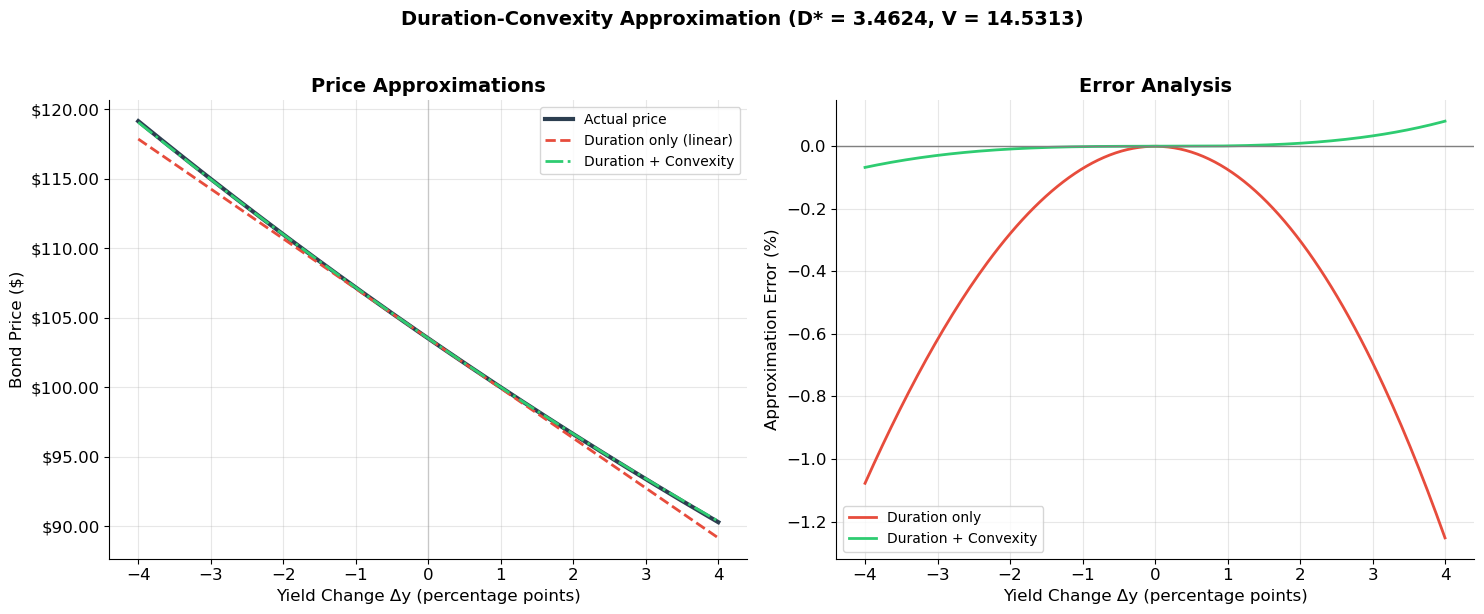

Yield move: 6% → 8% (+200 bps)
  Actual price:          $96.633628
  Duration approx:       $96.342094  (error: $0.291533)
  Duration+Convexity:    $96.642921  (error: $0.009294)
  Convexity reduces error by 31×


In [13]:
# ============================================================
# Duration vs. Duration-Convexity Approximation
# ============================================================
# ▶ MODIFY BOND PARAMETERS AND RE-RUN
face, coupon_rate, maturity, ytm_base, freq = 100, 0.07, 4, 0.06, 2
# ============================================================

P_base = bond_price_from_ytm(face, coupon_rate, maturity, ytm_base, freq)
D_star = modified_duration(face, coupon_rate, maturity, ytm_base, freq)
V = bond_convexity(face, coupon_rate, maturity, ytm_base, freq)

dy_range = np.linspace(-0.04, 0.04, 200)

actual_prices = np.array([bond_price_from_ytm(face, coupon_rate, maturity, ytm_base + dy, freq) for dy in dy_range])
duration_approx = P_base * (1 - D_star * dy_range)
dur_conv_approx = P_base * (1 - D_star * dy_range + 0.5 * V * dy_range**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Price approximations
ax1.plot(dy_range * 100, actual_prices, color='#2c3e50', linewidth=3, label='Actual price')
ax1.plot(dy_range * 100, duration_approx, color='#e74c3c', linewidth=2, linestyle='--', label='Duration only (linear)')
ax1.plot(dy_range * 100, dur_conv_approx, color='#2ecc71', linewidth=2, linestyle='-.', label='Duration + Convexity')

ax1.axvline(x=0, color='gray', linewidth=1, alpha=0.3)
ax1.set_xlabel('Yield Change Δy (percentage points)', fontsize=12)
ax1.set_ylabel('Bond Price ($)', fontsize=12)
ax1.set_title('Price Approximations', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.2f}'))

# Right: Approximation errors
err_dur = (duration_approx - actual_prices) / actual_prices * 100
err_dc = (dur_conv_approx - actual_prices) / actual_prices * 100

ax2.plot(dy_range * 100, err_dur, color='#e74c3c', linewidth=2, label='Duration only')
ax2.plot(dy_range * 100, err_dc, color='#2ecc71', linewidth=2, label='Duration + Convexity')
ax2.axhline(y=0, color='gray', linewidth=1)

ax2.set_xlabel('Yield Change Δy (percentage points)', fontsize=12)
ax2.set_ylabel('Approximation Error (%)', fontsize=12)
ax2.set_title('Error Analysis', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)

fig.suptitle(f'Duration-Convexity Approximation (D* = {D_star:.4f}, V = {V:.4f})',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Lo's slide 43 numerical check: y moves from 6% to 8%
dy_test = 0.02
P_actual = bond_price_from_ytm(face, coupon_rate, maturity, ytm_base + dy_test, freq)
P_dur = P_base * (1 - D_star * dy_test)
P_dc = P_base * (1 - D_star * dy_test + 0.5 * V * dy_test**2)

print(f"Yield move: {ytm_base:.0%} → {ytm_base + dy_test:.0%} (+{dy_test*10000:.0f} bps)")
print(f"  Actual price:          ${P_actual:.6f}")
print(f"  Duration approx:       ${P_dur:.6f}  (error: ${abs(P_dur - P_actual):.6f})")
print(f"  Duration+Convexity:    ${P_dc:.6f}  (error: ${abs(P_dc - P_actual):.6f})")
print(f"  Convexity reduces error by {abs(P_dur-P_actual)/abs(P_dc-P_actual):.0f}×")

---

<a id='5-immunization'></a>
## 5. Immunization and Hedging

### Duration Matching (Immunization)

A key application of duration is **immunization**: constructing a portfolio whose value is insensitive to small parallel shifts in the yield curve.

**Goal:** You have a liability due in $T$ years and want to invest in bonds such that the portfolio is protected against interest rate changes.

**Strategy:** Match the **modified duration** of assets to the **modified duration** of liabilities.

If you hold a bond portfolio with value $P_A$ and modified duration $D^*_A$, and want to hedge a liability with value $P_L$ and modified duration $D^*_L$:

$$\boxed{P_A \times D^*_A = P_L \times D^*_L}$$

This ensures that for small yield changes, the change in asset value offsets the change in liability value.

### Hedging with a Different Bond

Suppose you are long a 4-year bond and want to hedge using 3-year bonds. You need:

$$\delta = -\frac{D^*_4 \times P_4}{D^*_3 \times P_3}$$

The hedge ratio $\delta$ tells you how many dollars of the 3-year bond to short per dollar of the 4-year bond.

### Limitations

- Duration matching only works for **small, parallel** yield curve shifts
- The hedge must be **rebalanced** as time passes and yields change
- For large or non-parallel shifts, convexity matching provides additional protection

IMMUNIZATION — Pension Fund Liability Matching
Liability PV:         $  10,000,000
Liability duration:            7.0 years

Available instruments:
  3-year zero (D = 3):  weight = 42.86%
  10-year zero (D = 10): weight = 57.14%

Portfolio allocation:
  3-year zeros:  $   4,285,714
  10-year zeros: $   5,714,286
  Total invested: $  10,000,000
  Portfolio D:    7.0 years ✓


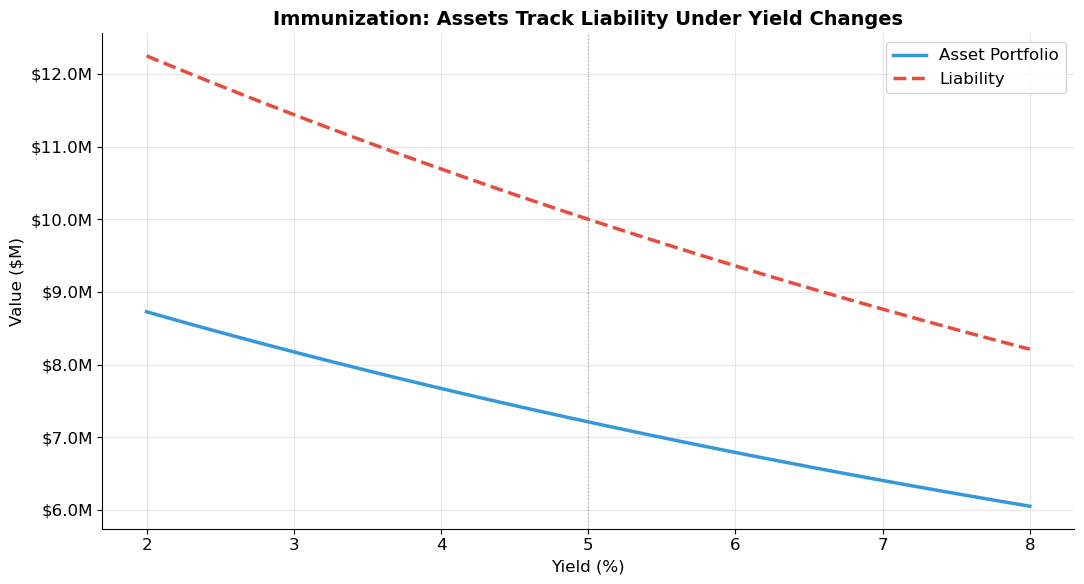

The portfolio value closely tracks the liability for small yield shifts.
This is duration matching (immunization) in action.


In [15]:
# ============================================================
# Immunization Example
# ============================================================
# Pension fund has a $10M liability due in 7 years.
# Available instruments: 3-year and 10-year zero-coupon bonds, both yielding 5%.

# ▶ MODIFY AND RE-RUN
liability_pv = 10_000_000
liability_duration = 7.0
ytm_market = 0.05
T_short = 3
T_long = 10
# ============================================================

# Zero-coupon durations = maturity
D_short = T_short
D_long = T_long

# Weights: w * D_short + (1-w) * D_long = liability_duration
w_short = (D_long - liability_duration) / (D_long - D_short)
w_long = 1 - w_short

invest_short = liability_pv * w_short
invest_long = liability_pv * w_long

print("=" * 60)
print("IMMUNIZATION — Pension Fund Liability Matching")
print("=" * 60)
print(f"Liability PV:         ${liability_pv:>12,.0f}")
print(f"Liability duration:   {liability_duration:>12.1f} years")
print(f"\nAvailable instruments:")
print(f"  {T_short}-year zero (D = {D_short}):  weight = {w_short:.2%}")
print(f"  {T_long}-year zero (D = {D_long}): weight = {w_long:.2%}")
print(f"\nPortfolio allocation:")
print(f"  {T_short}-year zeros:  ${invest_short:>12,.0f}")
print(f"  {T_long}-year zeros: ${invest_long:>12,.0f}")
print(f"  Total invested: ${invest_short + invest_long:>12,.0f}")
print(f"  Portfolio D:    {w_short * D_short + w_long * D_long:.1f} years ✓")

# Test: yield shifts up 100bp — are we hedged?
yields_test = np.linspace(0.02, 0.08, 100)
port_values = []
liab_values = []

for y in yields_test:
    p_short = invest_short / (1 + ytm_market)**T_short * (1 + ytm_market)**T_short / (1 + y)**T_short
    p_long = invest_long / (1 + ytm_market)**T_long * (1 + ytm_market)**T_long / (1 + y)**T_long
    port_values.append(p_short + p_long)
    
    # Liability also reprices
    liab_fv = liability_pv * (1 + ytm_market)**liability_duration  # FV at maturity
    liab_values.append(liab_fv / (1 + y)**liability_duration)

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(yields_test * 100, np.array(port_values) / 1e6, color='#3498db', linewidth=2.5, label='Asset Portfolio')
ax.plot(yields_test * 100, np.array(liab_values) / 1e6, color='#e74c3c', linewidth=2.5, linestyle='--', label='Liability')
ax.axvline(x=ytm_market * 100, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax.set_xlabel('Yield (%)', fontsize=12)
ax.set_ylabel('Value ($M)', fontsize=12)
ax.set_title('Immunization: Assets Track Liability Under Yield Changes', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.1f}M'))

plt.tight_layout()
plt.show()

print("The portfolio value closely tracks the liability for small yield shifts.")
print("This is duration matching (immunization) in action.")

---

<a id='6-credit-risk'></a>
## 6. Corporate Bonds and Default Risk

### Beyond Government Bonds

Government bonds are (approximately) riskless — the government can always print money to pay nominal obligations. Corporate bonds carry **default risk**: the issuer may fail to make promised payments.

### Credit Ratings

Rating agencies (Moody's, S&P, Fitch) assess default likelihood:

| Grade | Moody's | S&P | Description |
|-------|---------|-----|-------------|
| **Investment Grade** | | | |
| Highest | Aaa | AAA | Extremely strong |
| High | Aa | AA | Very strong |
| Upper Medium | A | A | Strong |
| Medium | Baa | BBB | Adequate (lowest IG) |
| **Speculative (Junk)** | | | |
| Somewhat | Ba | BB | Speculative elements |
| Speculative | B | B | More vulnerable |
| Highly | Caa | CCC | Currently vulnerable |
| Default | C/D | D | In default |

The dividing line between **investment grade** and **speculative** (Baa/BBB) is critical — many institutional investors (pension funds, insurance companies) are restricted to investment grade.

### Yield Decomposition

Lo decomposes a corporate bond yield into components:

$$\boxed{y_{\text{corporate}} = y_{\text{risk-free}} + \underbrace{\text{Default Premium}}_{\text{expected loss}} + \underbrace{\text{Risk Premium}}_{\text{compensation for risk}} + \text{Liquidity, Tax, etc.}}$$

- **Promised YTM**: the yield if default *does not* occur
- **Expected YTM**: probability-weighted average of all outcomes
- **Default premium** = Promised YTM − Expected YTM
- **Risk premium** = Expected YTM − Risk-free YTM

In [17]:
# ============================================================
# Lo's Corporate Bond Yield Decomposition Example
# ============================================================
# From slide 47-48: 10-year zeros
# Treasury STRIPS: Price = $463.19, Face = $1,000
# XYZ Corp zero: Price = $321.97, Face = $1,000
# Expected payoff of XYZ: $762.22

F = 1000
P_treasury = 463.19
P_xyz = 321.97
E_payoff_xyz = 762.22
T = 10

# Yields
y_riskfree = (F / P_treasury)**(1/T) - 1
y_promised = (F / P_xyz)**(1/T) - 1
y_expected = (E_payoff_xyz / P_xyz)**(1/T) - 1

# Decomposition
default_premium = y_promised - y_expected
risk_premium = y_expected - y_riskfree

print("=" * 60)
print("CORPORATE BOND YIELD DECOMPOSITION — Lo's Example")
print("=" * 60)
print(f"10-Year Treasury STRIPS:  P = ${P_treasury:.2f},  YTM = {y_riskfree:.4%}")
print(f"10-Year XYZ Corp Zero:    P = ${P_xyz:.2f},  Face = ${F:,.0f}")
print(f"Expected payoff (XYZ):    ${E_payoff_xyz:.2f}")
print()
print(f"{'Component':>20s} {'Yield':>10s}")
print("-" * 35)
print(f"{'Risk-free yield':>20s} {y_riskfree:>10.4%}")
print(f"{'+ Risk premium':>20s} {risk_premium:>+10.4%}")
print(f"{'= Expected YTM':>20s} {y_expected:>10.4%}")
print(f"{'+ Default premium':>20s} {default_premium:>+10.4%}")
print(f"{'= Promised YTM':>20s} {y_promised:>10.4%}")
print("-" * 35)
total_spread = y_promised - y_riskfree
print(f"{'Total Credit Spread':>20s} {total_spread:>10.4%}")
print(f"\nOf the {total_spread*10000:.0f}bp spread over Treasuries:")
print(f"  {default_premium/total_spread*100:.0f}% is default premium (expected loss)")
print(f"  {risk_premium/total_spread*100:.0f}% is risk premium (compensation for bearing risk)")

CORPORATE BOND YIELD DECOMPOSITION — Lo's Example
10-Year Treasury STRIPS:  P = $463.19,  YTM = 8.0001%
10-Year XYZ Corp Zero:    P = $321.97,  Face = $1,000
Expected payoff (XYZ):    $762.22

           Component      Yield
-----------------------------------
     Risk-free yield    8.0001%
      + Risk premium   +0.9999%
      = Expected YTM    9.0000%
   + Default premium   +3.0001%
      = Promised YTM   12.0001%
-----------------------------------
 Total Credit Spread    4.0000%

Of the 400bp spread over Treasuries:
  75% is default premium (expected loss)
  25% is risk premium (compensation for bearing risk)


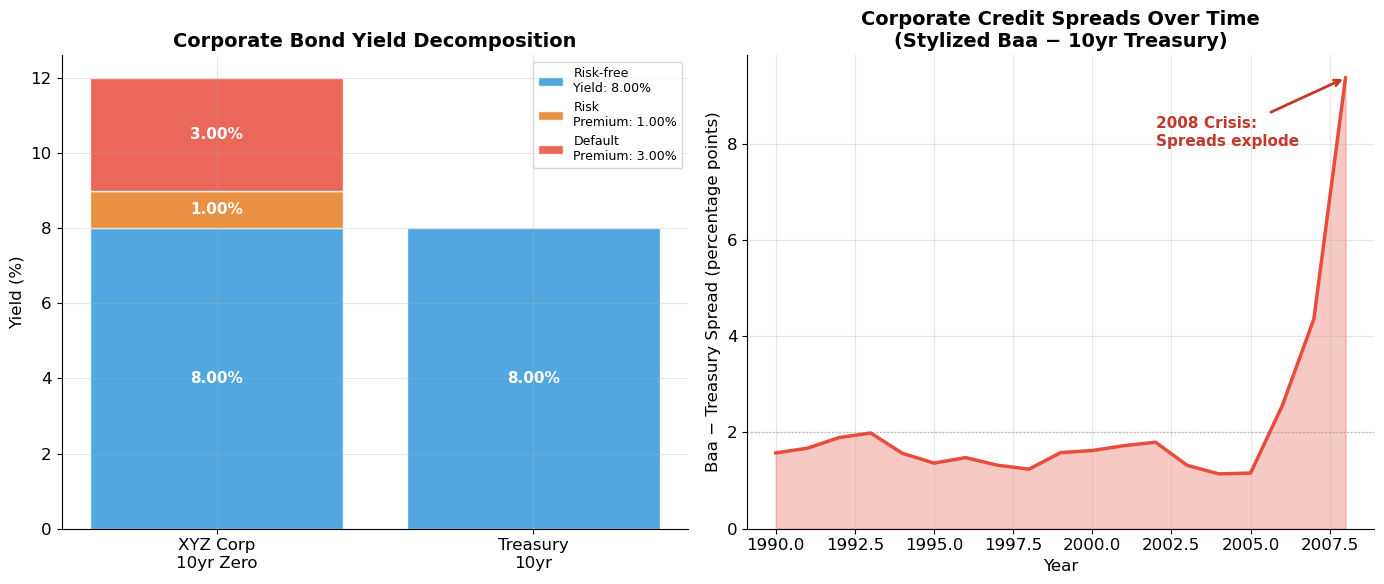

In [18]:
# ============================================================
# Visualization: Credit Spreads and Yield Decomposition
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Yield decomposition bar chart
components = ['Risk-free\nYield', 'Risk\nPremium', 'Default\nPremium']
values = [y_riskfree * 100, risk_premium * 100, default_premium * 100]
colors = ['#3498db', '#e67e22', '#e74c3c']
bottom = 0
for comp, val, color in zip(components, values, colors):
    ax1.bar('XYZ Corp\n10yr Zero', val, bottom=bottom, color=color, alpha=0.85,
            edgecolor='white', label=f'{comp}: {val:.2f}%')
    ax1.text(0, bottom + val/2, f'{val:.2f}%', ha='center', va='center',
            fontsize=11, fontweight='bold', color='white')
    bottom += val

ax1.bar('Treasury\n10yr', y_riskfree * 100, color='#3498db', alpha=0.85, edgecolor='white')
ax1.text(1, y_riskfree * 100 / 2, f'{y_riskfree*100:.2f}%', ha='center', va='center',
        fontsize=11, fontweight='bold', color='white')

ax1.set_ylabel('Yield (%)', fontsize=12)
ax1.set_title('Corporate Bond Yield Decomposition', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9, loc='upper right')

# Right: Historical credit spreads (stylized)
np.random.seed(42)
years = np.arange(1990, 2009)
base_spread = 1.5 + 0.3 * np.sin(np.linspace(0, 4*np.pi, len(years)))
crisis_bump = np.zeros(len(years))
crisis_bump[-3:] = [1.5, 3.0, 8.0]  # 2006-2008 crisis
spreads = base_spread + crisis_bump + np.random.normal(0, 0.15, len(years))
spreads = np.maximum(spreads, 0.5)

ax2.fill_between(years, 0, spreads, alpha=0.3, color='#e74c3c')
ax2.plot(years, spreads, color='#e74c3c', linewidth=2.5)
ax2.axhline(y=2.0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax2.annotate('2008 Crisis:\nSpreads explode', xy=(2008, spreads[-1]),
            xytext=(2002, spreads[-1] * 0.85),
            fontsize=11, color='#c0392b', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#c0392b', lw=2))

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Baa − Treasury Spread (percentage points)', fontsize=12)
ax2.set_title('Corporate Credit Spreads Over Time\n(Stylized Baa − 10yr Treasury)', fontsize=14, fontweight='bold')
ax2.set_ylim(0)

plt.tight_layout()
plt.show()

---

<a id='7-securitization'></a>
## 7. Securitization and the Sub-Prime Crisis

### What Is Securitization?

Securitization takes a pool of risky assets (loans) and repackages them into **tranches** with different risk profiles. The idea is to create securities that are *safer* than the individual underlying loans.

**Benefits (in theory):**
- Repackages risks into more homogeneous categories
- More efficient allocation of risk across different investor types
- Creates additional risk-bearing capacity
- Provides transparency and supports economic growth

**Requirements for success:**
- **Diversification** across loans
- **Accurate risk measurement**
- **Normal market conditions** (no systemic shocks)
- **Reasonably sophisticated investors**

### Lo's Two-Bond CDO Example

This is one of the most important examples in the course. Lo strips the CDO mechanism to its bare essence to reveal the hidden role of **correlation**.

**Setup:**
- Two identical 1-year bonds, each with \$1,000 face value
- Each bond defaults with probability 10% (pays \$0) or pays off with probability 90% (pays \$1,000)
- Price of each bond = 0.9 × \$1,000 + 0.1 × \$0 = **\$900**

**Step 1: Pool them together.** Create a portfolio of both bonds.

**Step 2: Tranche them.** Issue two new claims on the portfolio:
- **Senior tranche** (\$1,000): gets paid first
- **Junior tranche** (\$1,000): gets whatever is left

The key question: what are the tranches worth? **It depends entirely on the correlation of defaults.**

In [20]:
# ============================================================
# Lo's CDO Example: Independent Defaults
# ============================================================
face_per_bond = 1000
prob_default = 0.10
prob_pay = 1 - prob_default
n_bonds = 2

# Individual bond pricing
bond_price = prob_pay * face_per_bond + prob_default * 0
print("=" * 70)
print("Lo's CDO EXAMPLE — Two-Bond Securitization")
print("=" * 70)
print(f"Each bond: Face = ${face_per_bond:,}, Default prob = {prob_default:.0%}")
print(f"Each bond price: {prob_pay:.0%} × ${face_per_bond:,} + {prob_default:.0%} × $0 = ${bond_price:,.0f}")

# CASE 1: INDEPENDENT DEFAULTS
print("\n" + "=" * 70)
print("CASE 1: INDEPENDENT DEFAULTS")
print("=" * 70)

# Joint probabilities
p_both_pay = prob_pay ** 2             # 81%
p_one_defaults = 2 * prob_pay * prob_default  # 18%
p_both_default = prob_default ** 2     # 1%

states = [
    ('Both pay ($2,000)',    p_both_pay,      2000, 1000, 1000),
    ('One defaults ($1,000)', p_one_defaults, 1000, 1000, 0),
    ('Both default ($0)',    p_both_default,  0,    0,    0),
]

print(f"\n{'State':>25s} {'Prob':>8s} {'Portfolio':>12s} {'Senior':>10s} {'Junior':>10s}")
print("-" * 70)
senior_ev = 0
junior_ev = 0
for name, prob, port, sen, jun in states:
    print(f"{name:>25s} {prob:>8.0%} {port:>12,} {sen:>10,} {jun:>10,}")
    senior_ev += prob * sen
    junior_ev += prob * jun

print("-" * 70)
print(f"{'Expected Value':>25s} {'':>8s} {'$'+f'{senior_ev+junior_ev:,.0f}':>12s} {'$'+f'{senior_ev:,.0f}':>10s} {'$'+f'{junior_ev:,.0f}':>10s}")

# Default probabilities of tranches
senior_default_prob = p_both_default
junior_default_prob = p_one_defaults + p_both_default

print(f"\nSenior tranche: default prob = {senior_default_prob:.0%}  (was 10% per individual bond!)")
print(f"Junior tranche: default prob = {junior_default_prob:.0%}  (higher than individual)")
print(f"\n→ Diversification + tranching turned a 10%-default bond into a")
print(f"  Senior tranche with only {senior_default_prob:.0%} default probability — AAA territory!")

Lo's CDO EXAMPLE — Two-Bond Securitization
Each bond: Face = $1,000, Default prob = 10%
Each bond price: 90% × $1,000 + 10% × $0 = $900

CASE 1: INDEPENDENT DEFAULTS

                    State     Prob    Portfolio     Senior     Junior
----------------------------------------------------------------------
        Both pay ($2,000)      81%        2,000      1,000      1,000
    One defaults ($1,000)      18%        1,000      1,000          0
        Both default ($0)       1%            0          0          0
----------------------------------------------------------------------
           Expected Value                $1,800       $990       $810

Senior tranche: default prob = 1%  (was 10% per individual bond!)
Junior tranche: default prob = 19%  (higher than individual)

→ Diversification + tranching turned a 10%-default bond into a
  Senior tranche with only 1% default probability — AAA territory!


In [21]:
# ============================================================
# CASE 2: PERFECTLY CORRELATED DEFAULTS
# ============================================================
print("=" * 70)
print("CASE 2: PERFECTLY CORRELATED DEFAULTS")
print("=" * 70)
print("If the bonds ALWAYS default together (or pay together):")

states_corr = [
    ('Both pay ($2,000)',    prob_pay,     2000, 1000, 1000),
    ('Both default ($0)',    prob_default, 0,    0,    0),
]

print(f"\n{'State':>25s} {'Prob':>8s} {'Portfolio':>12s} {'Senior':>10s} {'Junior':>10s}")
print("-" * 70)
senior_ev_corr = 0
junior_ev_corr = 0
for name, prob, port, sen, jun in states_corr:
    print(f"{name:>25s} {prob:>8.0%} {port:>12,} {sen:>10,} {jun:>10,}")
    senior_ev_corr += prob * sen
    junior_ev_corr += prob * jun

print("-" * 70)
print(f"{'Expected Value':>25s} {'':>8s} {'$'+f'{senior_ev_corr+junior_ev_corr:,.0f}':>12s} {'$'+f'{senior_ev_corr:,.0f}':>10s} {'$'+f'{junior_ev_corr:,.0f}':>10s}")

print(f"\nSenior default prob: {prob_default:.0%}  (same as an individual bond!)")
print(f"Junior default prob: {prob_default:.0%}  (also same — correlation destroys diversification)")

print("\n" + "=" * 70)
print("COMPARISON: THE DEVASTATING EFFECT OF CORRELATION")
print("=" * 70)
print(f"{'':>25s} {'Independent':>15s} {'Correlated':>15s} {'Change':>12s}")
print("-" * 70)
print(f"{'Senior price':>25s} {'$'+f'{senior_ev:,.0f}':>15s} {'$'+f'{senior_ev_corr:,.0f}':>15s} {'$'+f'{senior_ev_corr - senior_ev:+,.0f}':>12s}")
print(f"{'Junior price':>25s} {'$'+f'{junior_ev:,.0f}':>15s} {'$'+f'{junior_ev_corr:,.0f}':>15s} {'$'+f'{junior_ev_corr - junior_ev:+,.0f}':>12s}")
print(f"{'Senior default prob':>25s} {senior_default_prob:>15.0%} {prob_default:>15.0%} {'10× worse!':>12s}")
print(f"\n→ The senior tranche goes from near-riskless (1% default)")
print(f"  to as risky as a single bond (10% default) — a TEN-FOLD increase!")
print(f"  This is EXACTLY what happened in the 2008 financial crisis.")

CASE 2: PERFECTLY CORRELATED DEFAULTS
If the bonds ALWAYS default together (or pay together):

                    State     Prob    Portfolio     Senior     Junior
----------------------------------------------------------------------
        Both pay ($2,000)      90%        2,000      1,000      1,000
        Both default ($0)      10%            0          0          0
----------------------------------------------------------------------
           Expected Value                $1,800       $900       $900

Senior default prob: 10%  (same as an individual bond!)
Junior default prob: 10%  (also same — correlation destroys diversification)

COMPARISON: THE DEVASTATING EFFECT OF CORRELATION
                              Independent      Correlated       Change
----------------------------------------------------------------------
             Senior price            $990            $900         $-90
             Junior price            $810            $900         $+90
      Senior d

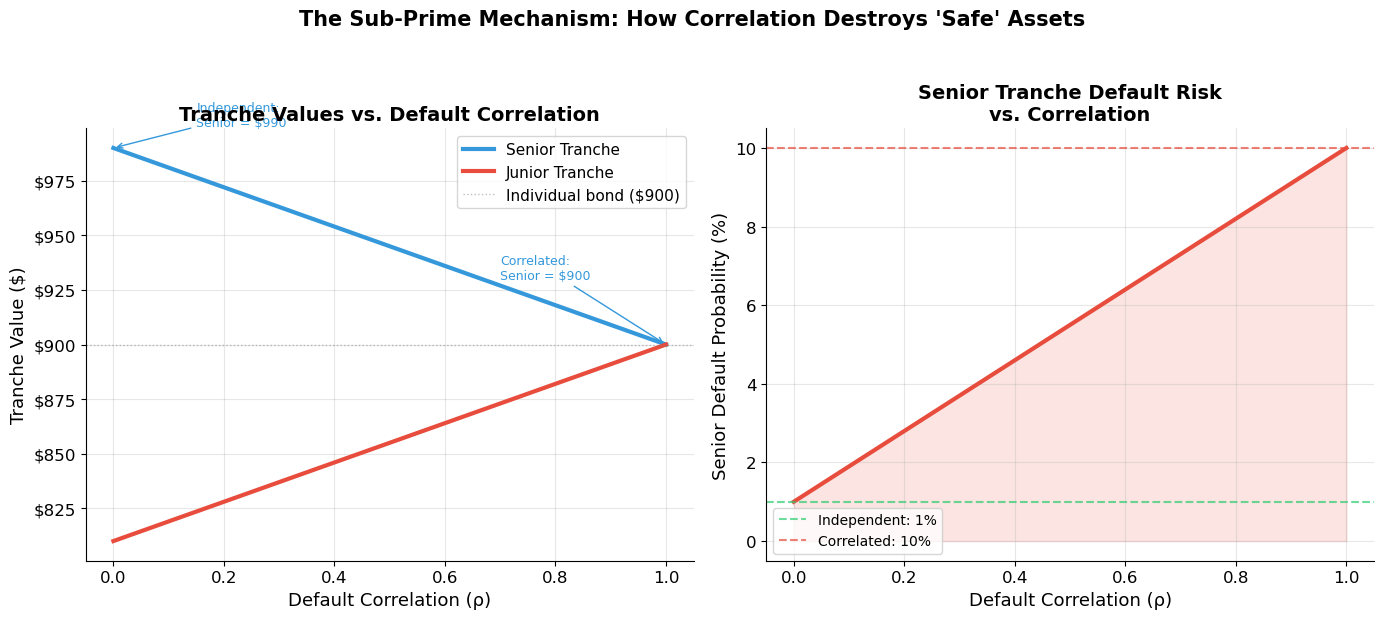

This is the sub-prime crisis in one graph:
• Rating agencies assumed low correlation → AAA rating for senior tranches
• When housing markets declined NATIONALLY, correlations spiked toward 1
• 'AAA' tranches suffered default rates 10× higher than rated
• Institutions holding these 'safe' assets faced catastrophic losses


In [22]:
# ============================================================
# Visualization: CDO Tranche Values vs. Correlation
# ============================================================
# Generalize: vary correlation from 0 (independent) to 1 (perfectly correlated)
# Using a simple bivariate model with mixing parameter rho

rho_range = np.linspace(0, 1, 100)
senior_prices = []
junior_prices = []
senior_def_probs = []

for rho in rho_range:
    # Joint default probability with correlation rho
    # P(both default) = rho * p + (1-rho) * p^2
    p_both_def = rho * prob_default + (1 - rho) * prob_default**2
    # P(exactly one defaults) = 2*p*(1-p) * (1-rho)
    p_one_def = (1 - rho) * 2 * prob_default * prob_pay
    # P(both pay) = 1 - p_both_def - p_one_def
    p_both_pay_rho = 1 - p_both_def - p_one_def
    
    # Senior gets $1000 unless both default
    s_price = (p_both_pay_rho + p_one_def) * 1000
    # Junior gets $1000 only if both pay
    j_price = p_both_pay_rho * 1000
    
    senior_prices.append(s_price)
    junior_prices.append(j_price)
    senior_def_probs.append(p_both_def * 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Tranche prices vs correlation
ax1.plot(rho_range, senior_prices, color='#3498db', linewidth=3, label='Senior Tranche')
ax1.plot(rho_range, junior_prices, color='#e74c3c', linewidth=3, label='Junior Tranche')
ax1.axhline(y=900, color='gray', linewidth=1, linestyle=':', alpha=0.5, label='Individual bond ($900)')

ax1.set_xlabel('Default Correlation (ρ)', fontsize=13)
ax1.set_ylabel('Tranche Value ($)', fontsize=13)
ax1.set_title('Tranche Values vs. Default Correlation', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Key points
ax1.annotate(f'Independent:\nSenior = ${senior_prices[0]:,.0f}', xy=(0, senior_prices[0]),
            xytext=(0.15, senior_prices[0] + 10), fontsize=9, color='#3498db',
            arrowprops=dict(arrowstyle='->', color='#3498db'))
ax1.annotate(f'Correlated:\nSenior = ${senior_prices[-1]:,.0f}', xy=(1, senior_prices[-1]),
            xytext=(0.7, senior_prices[-1] + 30), fontsize=9, color='#3498db',
            arrowprops=dict(arrowstyle='->', color='#3498db'))

# Right: Senior default probability vs correlation
ax2.plot(rho_range, senior_def_probs, color='#e74c3c', linewidth=3)
ax2.fill_between(rho_range, 0, senior_def_probs, alpha=0.15, color='#e74c3c')
ax2.axhline(y=1, color='#2ecc71', linewidth=1.5, linestyle='--', alpha=0.7, label='Independent: 1%')
ax2.axhline(y=10, color='#e74c3c', linewidth=1.5, linestyle='--', alpha=0.7, label='Correlated: 10%')

ax2.set_xlabel('Default Correlation (ρ)', fontsize=13)
ax2.set_ylabel('Senior Default Probability (%)', fontsize=13)
ax2.set_title('Senior Tranche Default Risk\nvs. Correlation', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)

fig.suptitle("The Sub-Prime Mechanism: How Correlation Destroys 'Safe' Assets",
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

print("This is the sub-prime crisis in one graph:")
print("• Rating agencies assumed low correlation → AAA rating for senior tranches")
print("• When housing markets declined NATIONALLY, correlations spiked toward 1")
print("• 'AAA' tranches suffered default rates 10× higher than rated")
print("• Institutions holding these 'safe' assets faced catastrophic losses")

### The Sub-Prime Narrative (Lo's Real-Time Account)

Lo connects the CDO mechanism to the actual crisis timeline:

1. **Pre-2007:** Very low default rates on mortgages. Very low correlation of defaults (regional, not national). Senior tranches correctly rated AAA under these assumptions. Enormous demand: pension funds bought senior tranches (safe yield), hedge funds bought junior tranches (high yield).

2. **2007–2008:** National real-estate market declines for the first time in decades. Default **correlation rises dramatically** — when one borrower defaults, nearby borrowers are also likely to default (falling house prices affect entire neighborhoods, cities, states).

3. **Consequence:** Senior tranches that were rated AAA with ~1% default probability suddenly face default rates of 10% or higher. Ratings agencies downgrade massively. Institutions that *could only hold investment-grade bonds* are forced to sell.

4. **Cascade:** Forced selling → further price declines → more defaults → more downgrades → more forced selling. This is the **death spiral** that brought down Lehman Brothers, Bear Stearns, AIG, and nearly the entire global financial system.

The key lesson: **securitization works brilliantly when defaults are independent, and catastrophically when they become correlated.** The model assumption of low correlation was the fatal flaw.

---

<a id='8-exercises'></a>
## 8. Exercises

### Exercise 1: Duration and Price Sensitivity

A 10-year bond has a face value of \$1,000, a 6% annual coupon, and is priced to yield 5%.

**(a)** Compute the Macaulay duration and modified duration.

**(b)** If yields rise by 50 basis points, estimate the percentage price change using duration. Compare with the actual price change.

**(c)** Now add convexity. Compute the bond's convexity and re-estimate the price change. How much does the convexity correction improve the approximation?

**(d)** Repeat parts (b)–(c) for a 200bp yield increase. When does convexity become essential?

In [25]:
# Exercise 1 — Workspace
# face, coupon_rate, maturity, ytm = 1000, 0.06, 10, 0.05
# P = bond_price_from_ytm(face, coupon_rate, maturity, ytm)
# D = macaulay_duration(face, coupon_rate, maturity, ytm)
# Dmod = modified_duration(face, coupon_rate, maturity, ytm)
# V = bond_convexity(face, coupon_rate, maturity, ytm)
# print(f"Price: ${P:,.2f}")
# print(f"Macaulay D: {D:.4f}")
# print(f"Modified D: {Dmod:.4f}")
# print(f"Convexity:  {V:.4f}")
#
# for dy in [0.005, 0.02]:
#     actual = bond_price_from_ytm(face, coupon_rate, maturity, ytm+dy)
#     dur_est = P * (1 - Dmod * dy)
#     dc_est = P * (1 - Dmod * dy + 0.5 * V * dy**2)
#     print(f"\nΔy = {dy*10000:.0f}bp:")
#     print(f"  Actual:  ${actual:,.2f}  ({(actual/P-1)*100:+.4f}%)")
#     print(f"  Dur:     ${dur_est:,.2f}  (error: ${abs(dur_est-actual):,.2f})")
#     print(f"  Dur+Conv:${dc_est:,.2f}  (error: ${abs(dc_est-actual):,.2f})")

### Exercise 2: Immunization

You manage a pension fund with a \$50M liability due in 8 years. Yields are currently 4% across all maturities. You can invest in:
- Bond A: 5-year, 3% annual coupon, \$1,000 par
- Bond B: 15-year, 5% annual coupon, \$1,000 par

**(a)** Compute the price, Macaulay duration, and modified duration of each bond.

**(b)** What portfolio weights (in Bonds A and B) immunize the liability?

**(c)** If yields jump to 5%, calculate the change in portfolio value and liability value. Is the portfolio still approximately hedged?

**(d)** Why might you prefer to use zero-coupon bonds for immunization instead of coupon bonds? What are the trade-offs?

In [27]:
# Exercise 2 — Workspace
# y = 0.04
# PA = bond_price_from_ytm(1000, 0.03, 5, y)
# PB = bond_price_from_ytm(1000, 0.05, 15, y)
# DA = macaulay_duration(1000, 0.03, 5, y)
# DB = macaulay_duration(1000, 0.05, 15, y)
# print(f"Bond A: P=${PA:,.2f}, D={DA:.4f}")
# print(f"Bond B: P=${PB:,.2f}, D={DB:.4f}")
#
# # Target duration = 8
# w_A = (DB - 8) / (DB - DA)
# w_B = 1 - w_A
# print(f"Weights: A={w_A:.4f}, B={w_B:.4f}")
# print(f"Portfolio D: {w_A*DA + w_B*DB:.4f}")

### Exercise 3: Securitization and Correlation

Consider a pool of **three** identical 1-year bonds, each with:
- Face value: \$1,000
- Default probability: 5%
- Defaults are independent

The pool is tranched into: Senior (\$1,000), Mezzanine (\$1,000), Equity (\$1,000).

**(a)** List all possible portfolio outcomes and their probabilities.

**(b)** Compute the expected payoff, price, and default probability for each tranche. Show that the senior tranche has a very low default probability.

**(c)** Now assume defaults are perfectly correlated. Recompute all tranche values and default probabilities. What happens to the senior tranche?

**(d)** Consider an intermediate case: 50% correlation (half the time defaults are independent, half the time they're perfectly correlated). Compute tranche values. How sensitive are the results to the correlation assumption?

**(e)** Discuss: why did rating agencies get this so wrong? What institutional incentives were at play?

In [29]:
# Exercise 3 — Workspace
# p_d = 0.05
# p_p = 0.95
#
# # Independent: 3 bonds, binomial distribution
# # k defaults out of 3:
# from math import comb
# for k in range(4):
#     prob = comb(3, k) * p_d**k * p_p**(3-k)
#     portfolio_val = (3-k) * 1000
#     senior = min(portfolio_val, 1000)
#     mezz = min(max(portfolio_val - 1000, 0), 1000)
#     equity = max(portfolio_val - 2000, 0)
#     print(f"k={k} defaults: prob={prob:.6f}, portfolio=${portfolio_val:,}, "
#           f"senior=${senior:,}, mezz=${mezz:,}, equity=${equity:,}")

---

## Key Takeaways — Session 5

1. **Macaulay duration** is the PV-weighted average time to receipt of cash flows. It measures bond "effective maturity."

2. **Modified duration** $D^* = D/(1+y/q)$ gives the percentage price sensitivity: $\Delta P/P \approx -D^* \times \Delta y$. It is the single most important number in fixed-income risk management.

3. **Convexity** captures curvature. The duration-convexity approximation $\Delta P/P \approx -D^* \Delta y + \frac{1}{2} V (\Delta y)^2$ is essential for large yield movements.

4. **Immunization** (duration matching) protects portfolios against small parallel yield shifts. It requires continuous rebalancing.

5. **Corporate bond yields** decompose into risk-free rate + default premium + risk premium + other factors.

6. **Securitization** creates tranches with different risk profiles from a pool of assets. **Diversification** across loans makes senior tranches very safe — *but only if defaults are independent*.

7. **The 2008 crisis** was fundamentally a correlation event: when housing markets declined nationally, default correlations spiked, AAA tranches suffered massive losses, and the "safe" became toxic.

---

## References

- **Brealey, R.A., Myers, S.C., and Allen, F.** *Principles of Corporate Finance*, Chapters 23–25.
- **MIT OCW 15.401:** [Fixed-Income Securities](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/fixed-income-securities/)
- **Macaulay, F.** (1938). *Some Theoretical Problems Suggested by the Movements of Interest Rates, Bond Yields and Stock Prices in the United States since 1856*. NBER.
- **Sundaresan, S.** (1997). *Fixed Income Markets and Their Derivatives*. South-Western.
- **Lo, A.W.** (2012). "Reading about the Financial Crisis: A Twenty-One Book Review." *Journal of Economic Literature*, 50(1), 151–178.

---

*Next: **Session 6 — Equities** — stock valuation, the dividend discount model, earnings multiples, and the price-to-earnings ratio.*